# Lesson 10 - Neighbours and clusters

> Use distance measures to classify and cluster data.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lewtun/dslectures/master?urlpath=lab/tree/notebooks%2Flesson10_clusters.ipynb) [![slides](https://img.shields.io/static/v1?label=slides&message=lesson10_clusters.pdf&color=blue&logo=Google-drive)](https://drive.google.com/open?id=1PZ_Yh3nK1qLVJoLBAc5nMpd2wyFQKKX8)

## Learning objectives
In this lesson we will have a look at distance and similarity measures to analyse data. If one can determine the distance between data samples (e.g. between rows in a table, different texts or images) one has access to a range of tools to investigate data and to model it. In this lesson we will have a look at two of them, namely k-nearest neighbour classification and k-means clustering. 

* **k-nearest neighbour** classification falls in the category of supervised algorithms, which we already encountered with Decision Trees and Random Forests.

* **k-means** clustering on the other hand is an unsupervised method and therefore forms a new class of algorithms. We will investigate how these algorithms can be used.

This notebook is split according to three learning goals:
1. Understand different measures of distance and the curse of dimensionality.
2. How the nearest neighbours can be used to build a classifier in scikit-learn.
3. Explore a dataset with the unsupervised k-means method.

## References
* Chapter 6: Similarity, Neighbors, and Clusters of _Data Science for Business_ by F. Provost and P. Fawcett

## Homework
Work through the notebook and solve the exercises.

<div style="text-align: center">
<img src='images/cluster-cats.png' width='300'>
    <p style="text-align: center;"> <b>Figure:</b> A group of cats is called a cluster. </p>
</div>

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

from dslectures.core import plot_classifier_boundaries, plot_fitting_graph

In [ ]:
# uncomment if on your laptop
# !pip install --upgrade dslectures

## Part 1: Similarity and distance measures

Similarity and distance measures are fundamental tools in machine learning. Often we want to know how far apart or similar two datapoints are. Some examples:

* How similar are two customers?
* How close is a search query to a webpage?
* How similar are two pictures?
* How far away is the closest restaurant?

How we measure the distance and similarity influences the results. If the direct, shortest path takes us over a cliff it might not actually be the shortest path time-wise. Also the dimensionality of the data has an impact on the usefulness of the result. When working with high-dimensional data one has to keep the _curse of dimensionality_ in mind that impacts the quality of some metrics.

<div style="text-align: center">
<img src='images/Obsolete_Russian_units_of_length.png' width='300'>
    <p style="text-align: center;"> <b>Figure:</b> Obsolete Russian measures of distance. </p>
</div>

See this [link](https://en.wikipedia.org/wiki/Obsolete_Russian_units_of_measurement) for more information about obsolete Russian units of measurement.

In this section we investigate how different measures of distance and similarity behave when more dimensions are added. In machine learning this means that we add more features to the feature matrix. This can have severe implications on the quality of distance measure and methods that rely on it (such as k-nearest neighbour or k-means). This is often called the **curse of dimensionality**.

First lets define a few distance/similarity measures. These functions calculate the distance/similarity between two vectors `x` and `y`:

In [ ]:
def euclidean_distance(x, y):
    """calculate euclidean distance between two arrays."""
    return np.linalg.norm(x-y)


def cos_similarity(x, y):
    """calculate cosine similarity between two arrays."""
    cos_sim = np.dot(x, y)/(np.linalg.norm(x)*np.linalg.norm(y))
    return cos_sim


def manhatten_distance(x, y):
    """calculate manhatten distance between two arrays."""
    #############
    # YOUR CODE #
    #############
    manhatten_dist= 1

    return manhatten_dist

Now we create pairs of random vectors with dimensionality ranging from 1 to 10000. For each dimension, we calculate the distance between the two vectors and store them in a list:

In [ ]:
euclidean_distances = []
cos_distances = []
manhatten_distances = []

dims = np.linspace(1, 10000, 1000).astype(int)

for dim in dims:
    x = np.random.rand(dim)
    y = np.random.rand(dim)
    
    euclidean_distances.append(euclidean_distance(x, y))
    cos_distances.append(cos_similarity(x, y))
    manhatten_distances.append(manhatten_distance(x, y))

This distance can be plotted in a graph:

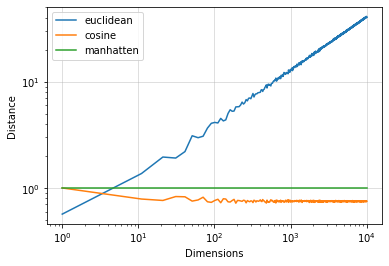

In [ ]:
plt.plot(dims, euclidean_distances, label='euclidean')
plt.plot(dims, cos_distances, label='cosine')
plt.plot(dims, manhatten_distances, label='manhatten')
plt.ylabel('Distance')
plt.xlabel('Dimensions')
plt.legend(loc='best')
plt.yscale('log')
plt.xscale('log')
plt.grid(True,alpha=0.5)
plt.show()


### Exercise 1
Implement the Manhatten-metric and add it to the scaling plot. The mathematical definition of the Manhatten-metric is:

$d_{Manhatten}(\vec{x},\vec{y})=\sum_{i=1}^{n}{\mid x_i - y_i \mid}$

Use the plot to investigate the following questions:

* How does it behave compared to the other two metrics? 
* What do you observe when you plot the y-axis on a linear scale (comment the line `plt.yscale('log')`)?

## Part 2: k-nearest neighbours

### Iris dataset

The iris dataset contains the sepal and petal width of three species of flowers. The three species are Iris setosa, Iris versicolor, and Iris virginica. It is one of the most iconic datasets in machine learning and has been around for more than 80 years! It is still widely used today because of its two features it is easy to visualise and study different algorithms on it. Going beyond 2 or 3 dimensions is very hard to visualise and we will study some methods in the next lesson to break down and visualise high dimensional data. For visualisation purposes we'll use the iris dataset in this lesson to investigate the 

<div style="text-align: center">
<img src='images/petal-sepal.jpg' width='300'>
    <p style="text-align: center;"> <b>Figure reference:</b> https://en.wikipedia.org/wiki/Petal#/media/File:Petal-sepal.jpg </p>
</div>



In [ ]:
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target

### k-nearest neighbours classifier

The k-nearest neighbours classifier uses the neighbours of a sample to classify it. Given a new point, it searches the k samples in the training set that are closest to the new point. Then the majority class of the neighbours is used to classify the new point. 

#### Example
Let's assume you are given a new flower and want to classify it using the iris dataset. You measure the petal and sepal width of your flower and compare it to the dataset. You decide to do a k=8 nearest neighbour search. You find that the nearest samples are:
* 5 Iris setosa
* 2 Iris versicolor
* 1 Iris virginica
Based on that observation you decide that your flower is a **Iris setosa**.

#### Tips & tricks
* Make sure all features are scaled properly (e.g. see `sklearn.preprocessing.StandardScaler`)
* Use odd number for k to avoid ties
* Voting can be weighted by distance

#### Usage
The `KNeighborsClassifier` interface is the same as the one we have already seen for the Decision Tree and Random Forest classifiers. When initializing the classifier one has to pass the number of neighbours `k` and can then use the known `.fit()` and `.predict()` procedure. We introduce the `plot_classifier_boundaries` to study the behaviour of the classifier more closely. 

> Note: The `plot_classifier_boundaries` function only works in two dimensions.

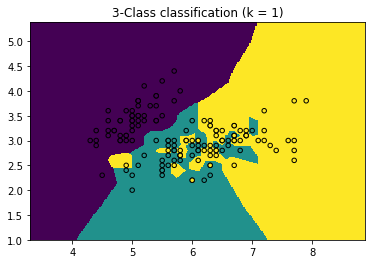

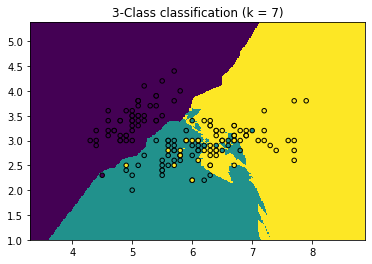

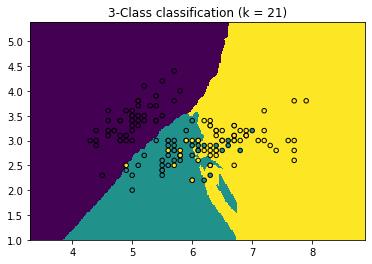

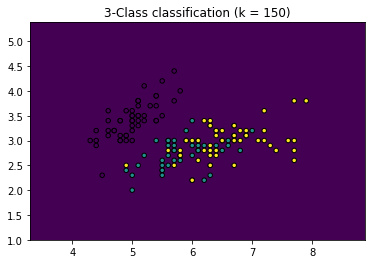

In [ ]:
for k in [1, 7, 21, len(y)]:
    
    clf = KNeighborsClassifier(k)
    clf.fit(X, y)
    
    plot_classifier_boundaries(X, y, clf)
    plt.title(f"3-Class classification (k = {k})")
    plt.show()

### Excercise 2
Create the fitting graph for the `kNeighborsClassifier` on the iris dataset with cross-validation. Run it for the following values of k: `np.linspace(1, 120, 120,).astype(int)` and use 5 folds (`cv=5`). What is the best value for `k`? And how do you interpre k=1 and k=n_samples? When are you most likely to overfit the data?

### Excercise 3
Use the `plot_classifier_boundaries` to plot the classifier boundaries with the following settings:
* `RandomForestClassifier(n_estimators=1, max_depth=1)`
* `RandomForestClassifier(n_estimators=1, max_depth=2)` 
* `RandomForestClassifier(n_estimators=100, max_depth=None)`

What do you observe? Can you explain it?

## Part 3: k-means clustering

We now turn to k-means clustering, an unsupervised approach. The goal is to automatically identify clusters in the data without having access to the labels. We will see that even without knowledge about the data we will be able to make statements about the shape of it.

In [ ]:
def plot_clustering_results(X, y, cluster_centers):
    """
    Plot results of k-means clustering.
    """
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.scatterplot(X[:,0], X[:,1],
                    hue=y, edgecolor='k',
                    palette="nipy_spectral",
                    legend=False)

    sns.scatterplot(cluster_centers[:, 0], cluster_centers[:, 1],
                    hue=list(range(np.shape(cluster_centers[:, 0])[0])),
                    palette="nipy_spectral", marker="o", edgecolor='k',
                    s=250, legend=False)
    plt.show()

The interface of k-mean provided in scikit-learn is very similar to that of a classifier.

**Initialize:**
We define the number of clusters we want to look for.
 ```python
    kmeans = KMeans(n_clusters=k)
 ```
**Fit:**
We fit the model to the data.
 ```python
    kmeans.fit(X)
 ```

**Predict:**
We make predictions to which cluster each datapoint belongs.
 ```python
    y = kmeans.predict(X)
 ```
_Note:_ In contrast to the classifiers, the k-means algorithm does **not** need any labels when the model is fitted to the data.

In addition to these standard functions has the trained model several additional features. On the one hand can the calculated cluster centers (or sometimes called centroids) be accessed:
 ```python
    kmeans.cluster_centers_
 ```
Furthermore, we can get the inertia, which is the sum of the squared distances of each datapoint to its closest cluster center.
 ```python
    kmeans.inertia_
 ```

We can cluster the dataset in two clusters and visualize the results:

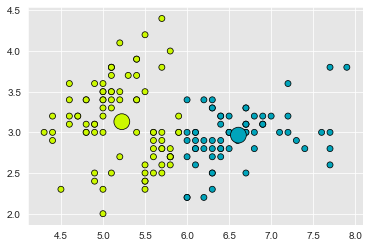

In [ ]:
kmeans = KMeans(n_clusters=2)

kmeans.fit(X)
y_hat = kmeans.predict(X)

plot_clustering_results(X, y_hat, kmeans.cluster_centers_)

We can also have a look at other values for k:

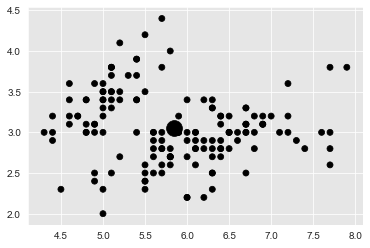

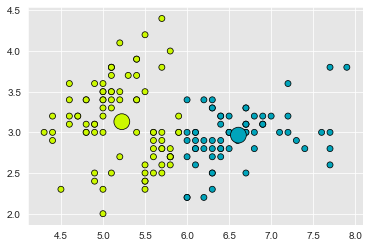

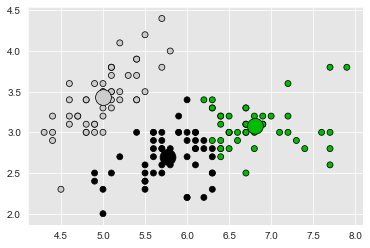

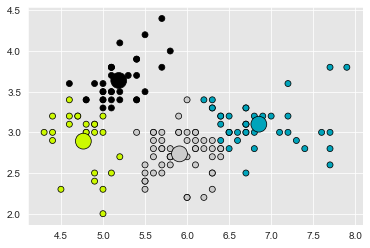

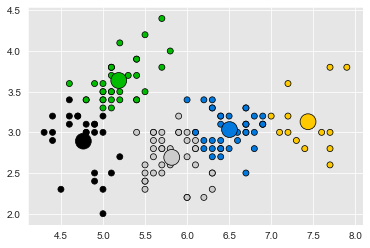

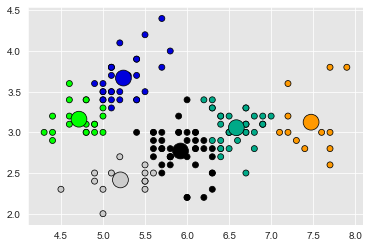

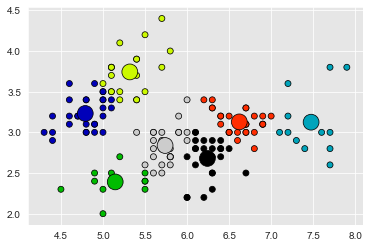

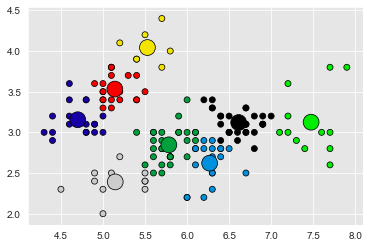

In [ ]:
ks = np.linspace(1,8,8).astype(int)

for k in ks:
    kmeans = KMeans(n_clusters=k)

    kmeans.fit(X)
    y_hat = kmeans.predict(X)
        
    plot_clustering_results(X, y_hat, kmeans.cluster_centers_)    

### The elbow rule
Looking at the results above it seems that the hardest part of k-means is to select the right number for k, which can be any positive integer. How can we find a good value for k?

There are several approaches, one of which is the so called **elbow rule**: Plot the inertia for different values of k. This yields an asymptotic curve that moves at first fast towards zero and then slows down. Imagine the curve is an arm. The spot where the elbow of that arm would be is usually a good value for k.

### Excercise 4
Run k-means for values for k between 1 and 8 and store the values of the inertia. Make a graph that plots the k's on the x-axis and the inertia on the y-axis. Applying the elbow rule, which value for k do you think would be a good fit?